(clv_quickstart)=
# CLV Quickstart

```{note}
This quickstart was adapted from the legacy [lifetimes](https://lifetimes.readthedocs.io/en/latest/Quickstart.html) library. Some pictures and descriptions are directly attributable to the `lifetimes` developers.
```

In this notebook we will be using the CDNOW dataset, a popular benchmarking dataset in CLV and Buy Till You Die (BTYD) modeling research. Data is available [here](https://www.brucehardie.com/datasets/), with additional details [here].

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arviz.labels import MapLabeller

from pymc_marketing import clv

In [2]:
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina" # nice looking plots

## 1.1 Data Requirements

For all models, the following nomenclature is used:

* `customer_id` represents a unique identifier for each customer.
* `frequency` represents the number of _repeat_ purchases that a customer has made, i.e. one less than the total number of purchases.
* `T` represents a customer's "age", i.e. the duration between a customer's first purchase and the end of the period of study. In this example notebook, the units of time are in weeks.
* `recency` represents the time period when a customer made their most recent purchase. This is equal to the duration between a customer’s first and last purchase. If a customer has made only 1 purchase, their recency is 0.
* `monetary_value` represents the average value of a given customer’s repeat purchases. Customers who have only made a single purchase have monetary values of zero.

The `rfm_summary` function can be used to preprocess raw transaction data for modeling:

In [3]:
raw_trans = pd.read_csv("https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/cdnow_transactions.csv")

raw_trans.head(5)

,_id,id,date,cds_bought,spent
0,4,1,19970101,2,29.33
1,4,1,19970118,2,29.73
2,4,1,19970802,1,14.96
3,4,1,19971212,2,26.48
4,21,2,19970101,3,63.34


In [4]:
rfm_data = clv.utils.rfm_summary(
    raw_trans,
    customer_id_col = "id",
    datetime_col = "date",
    monetary_value_col = "spent",
    datetime_format = "%Y%m%d",
    time_unit = "W")

rfm_data

,customer_id,frequency,recency,T,monetary_value
0,1,3.0,49.0,78.0,23.723333
1,2,1.0,2.0,78.0,11.770000
2,3,0.0,0.0,78.0,0.000000
3,4,0.0,0.0,78.0,0.000000
4,5,0.0,0.0,78.0,0.000000
...,...,...,...,...,...
2352,2353,2.0,53.0,66.0,19.775000
2353,2354,5.0,24.0,66.0,44.928000
2354,2355,1.0,44.0,66.0,24.600000
2355,2356,6.0,62.0,66.0,31.871667


It is important to note these definitions differ from that used in RFM segmentation, where the first purchase is included, `T` is not used, and `recency` is the number of time periods since a customer's most recent purchase.

To visualize data in RFM format, we can plot the recency and T of the customers with the `plot_customer_exposure` function. We see a large chunk (>60%) of customers haven't made another purchase in a while.

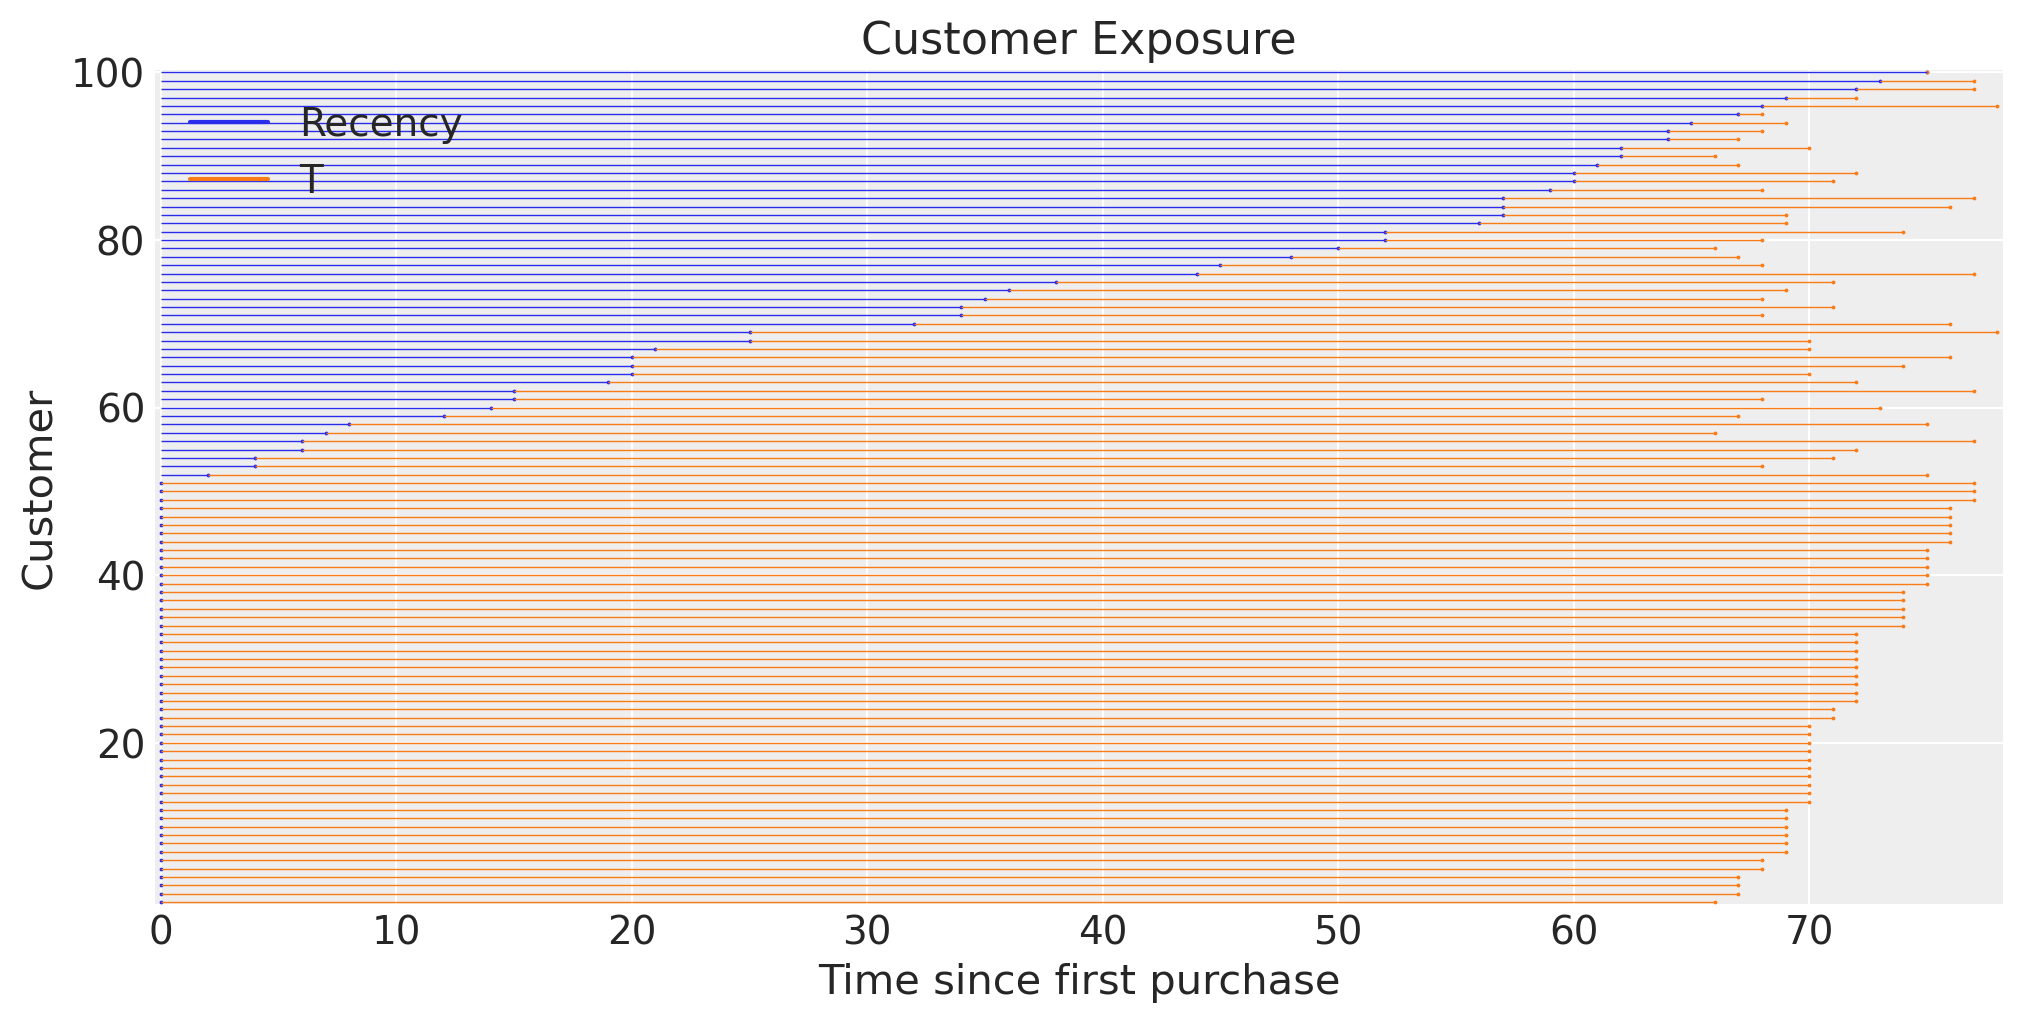

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    rfm_data
    .sample(n=100, random_state=42)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
);

## Basic Frequency/Recency analysis using the BG/NBD model

As this dataset represents non-contractual transactions in the continuous time domain, we will use the Beta-Geometric/Negative Binomial Distribution (BG/NBD) model to infer the frequency of repeat purchases for each customer in the dataset. The Pareto/Negative Binomial Distribution (Pareto/NBD) model is also available as an alternative if you wish to compare results.

For use cases involving discrete time, contractual transactions, use the Shifted Beta-Geometric model.

In [6]:
bgm = clv.BetaGeoModel(
    data = rfm_data
)
bgm.build_model()

This model has 4 parameters that specify the global frequency and dropout rates of customers.

In [7]:
bgm

BG/NBD
         a ~ HalfFlat()
         b ~ HalfFlat()
     alpha ~ HalfFlat()
         r ~ HalfFlat()
likelihood ~ Potential(f(r, alpha, b, a))

The default priors for the 4 parameters follow a HalfFlat distribution, which is an improper positive uniform distribution. For small datasets this prior can yield implausible posteriors. To avoid this problem, more informative priors can be specified by defining custom PyMC distributions.

Here, we will replace the HalfFlat default by more well-behaved HalfNormal priors with a standard deviation of 10.
Customization priors is possible by passing a dictionary with keys being the name of the prior, and values being a dictionary with 2 keys: 'dist' representing the name of PyMC distribution and 'kwargs' that holds an optional dictionary of all parameters we wish to pass to the distribution

In [8]:
model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
}

In [9]:
bgm = clv.BetaGeoModel(
    data = rfm_data,
    model_config = model_config,
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfNormal(0, 10)
         b ~ HalfNormal(0, 10)
     alpha ~ HalfNormal(0, 10)
         r ~ HalfNormal(0, 10)
likelihood ~ Potential(f(r, alpha, b, a))

Having specified the model, we can now fit it.

In [10]:
bgm.fit()
bgm.fit_summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha, r]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.691,0.160,0.422,0.990,0.004,0.003,1618.0,1678.0,1.0
alpha,7.115,0.512,6.208,8.130,0.011,0.008,1992.0,1980.0,1.0
b,3.288,1.007,1.686,5.131,0.025,0.018,1587.0,1770.0,1.0
r,0.276,0.012,0.253,0.298,0.000,0.000,2138.0,2238.0,1.0


We can use [ArviZ](https://python.arviz.org/en/stable/), a Python library tailored to produce visualizations for Bayesian models, to plot the posterior distribution of each parameter.

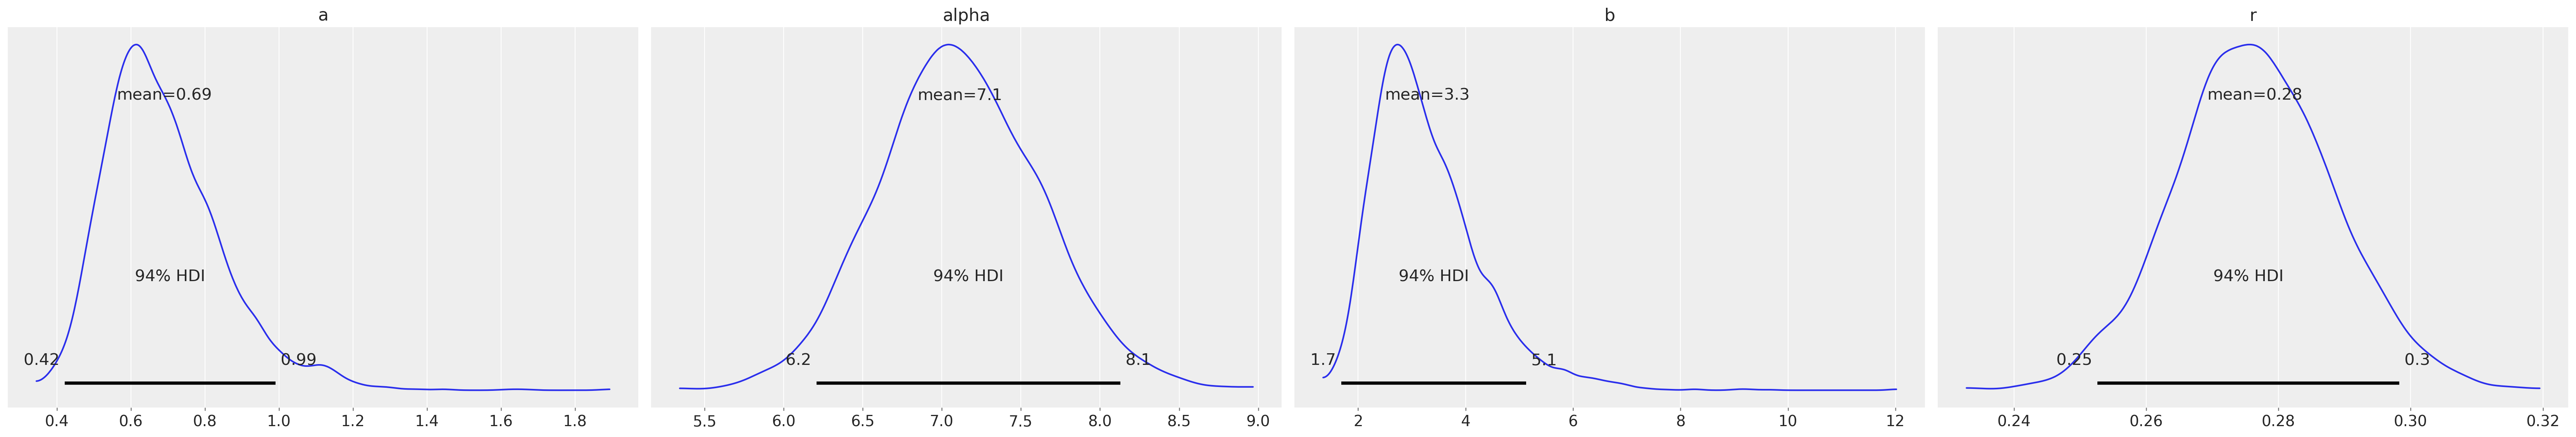

In [11]:
az.plot_posterior(bgm.fit_result);

### Visualizing the Frequency/Recency Matrix

/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/models/beta_geo.py:303: FutureWarning: Deprecated method. Use 'expected_purchases' instead.
  warnings.warn(


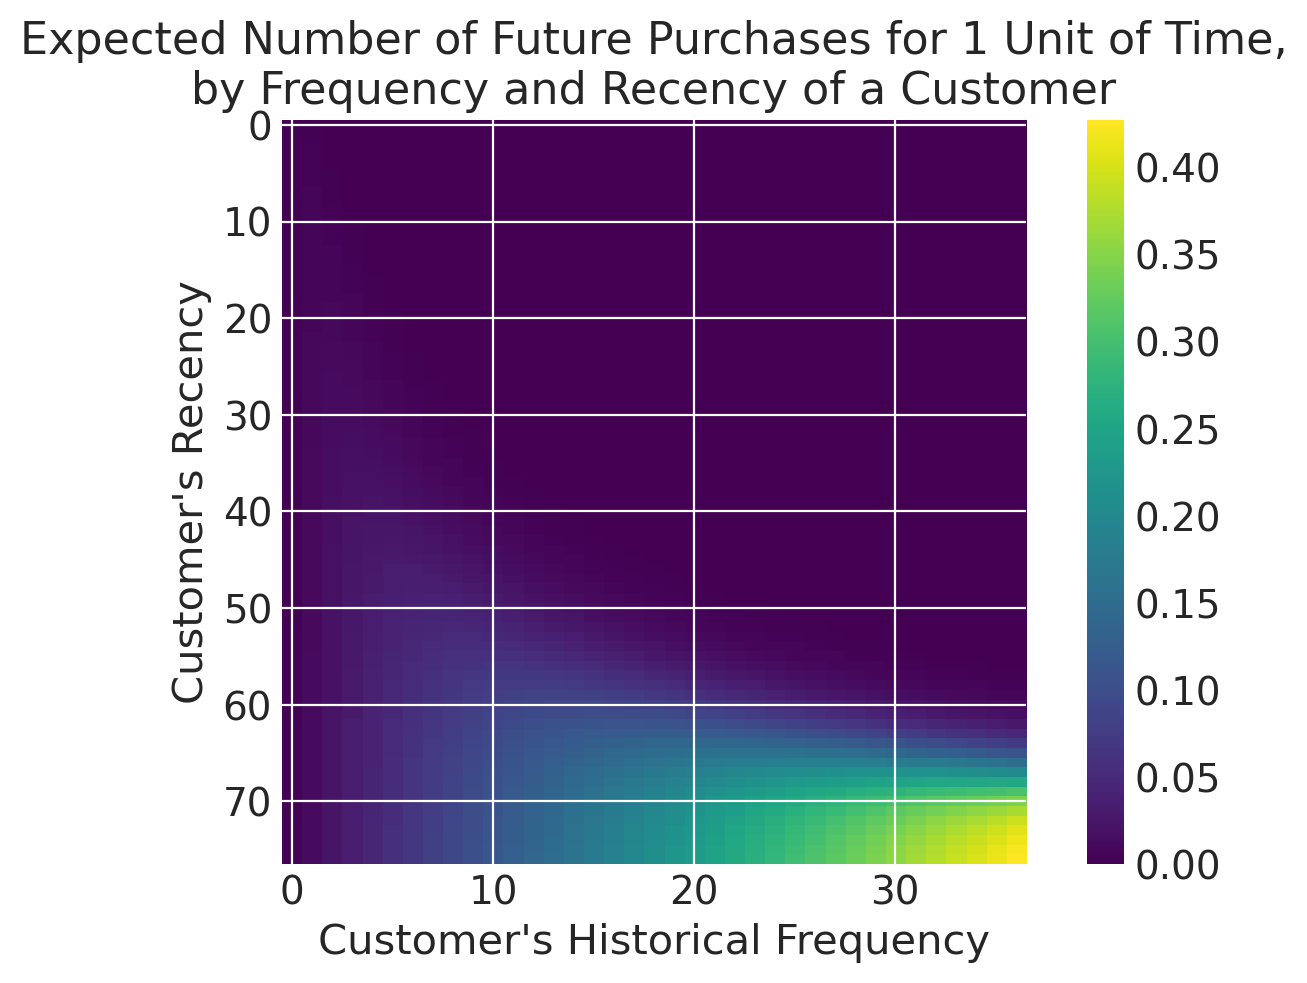

In [12]:
clv.plot_frequency_recency_matrix(bgm);

We can see our best customers have been active for over 60 weeks and have made over 20 purchases (bottom-right). Note the “tail” sweeping up towards the upper-left corner - these customers are infrequent and/or may not have purchased recently. What is the probability they are still active? 

In [13]:
clv.plot_probability_alive_matrix(bgm)

TypeError: BetaGeoModel.expected_probability_alive() got an unexpected keyword argument 'customer_id'

Note that all non-repeat customers have an alive probability of 1, which is one of the quirks of `BetaGeoModel`. In many use cases this is still a valid assumption, but if non-repeat customers are a key focus in your use case, you may want to try `ParetoNBDModel` instead.  

Looking at the probability alive matrix, we can infer that customers who have made fewer purchases are less likely to return, and may be worth targeting for retention.

### Ranking customers from best to worst

Having fit the model, we can ask what is the expected number of purchases for our customers in the next period. Let's look at the four more promising customers.

In [14]:
num_purchases = bgm.expected_purchases(future_t=10)

sdata = rfm_data.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
sdata.sort_values(by="expected_purchases").tail(4)

,customer_id,frequency,recency,T,monetary_value,expected_purchases
812,813,30.0,72.0,74.0,35.654000,3.440724
1202,1203,32.0,71.0,72.0,47.172187,3.811448
156,157,36.0,74.0,77.0,30.603611,3.898155
1980,1981,35.0,66.0,68.0,46.748857,4.304929


We can plot the uncertainty in the expected number of purchases in the next period.

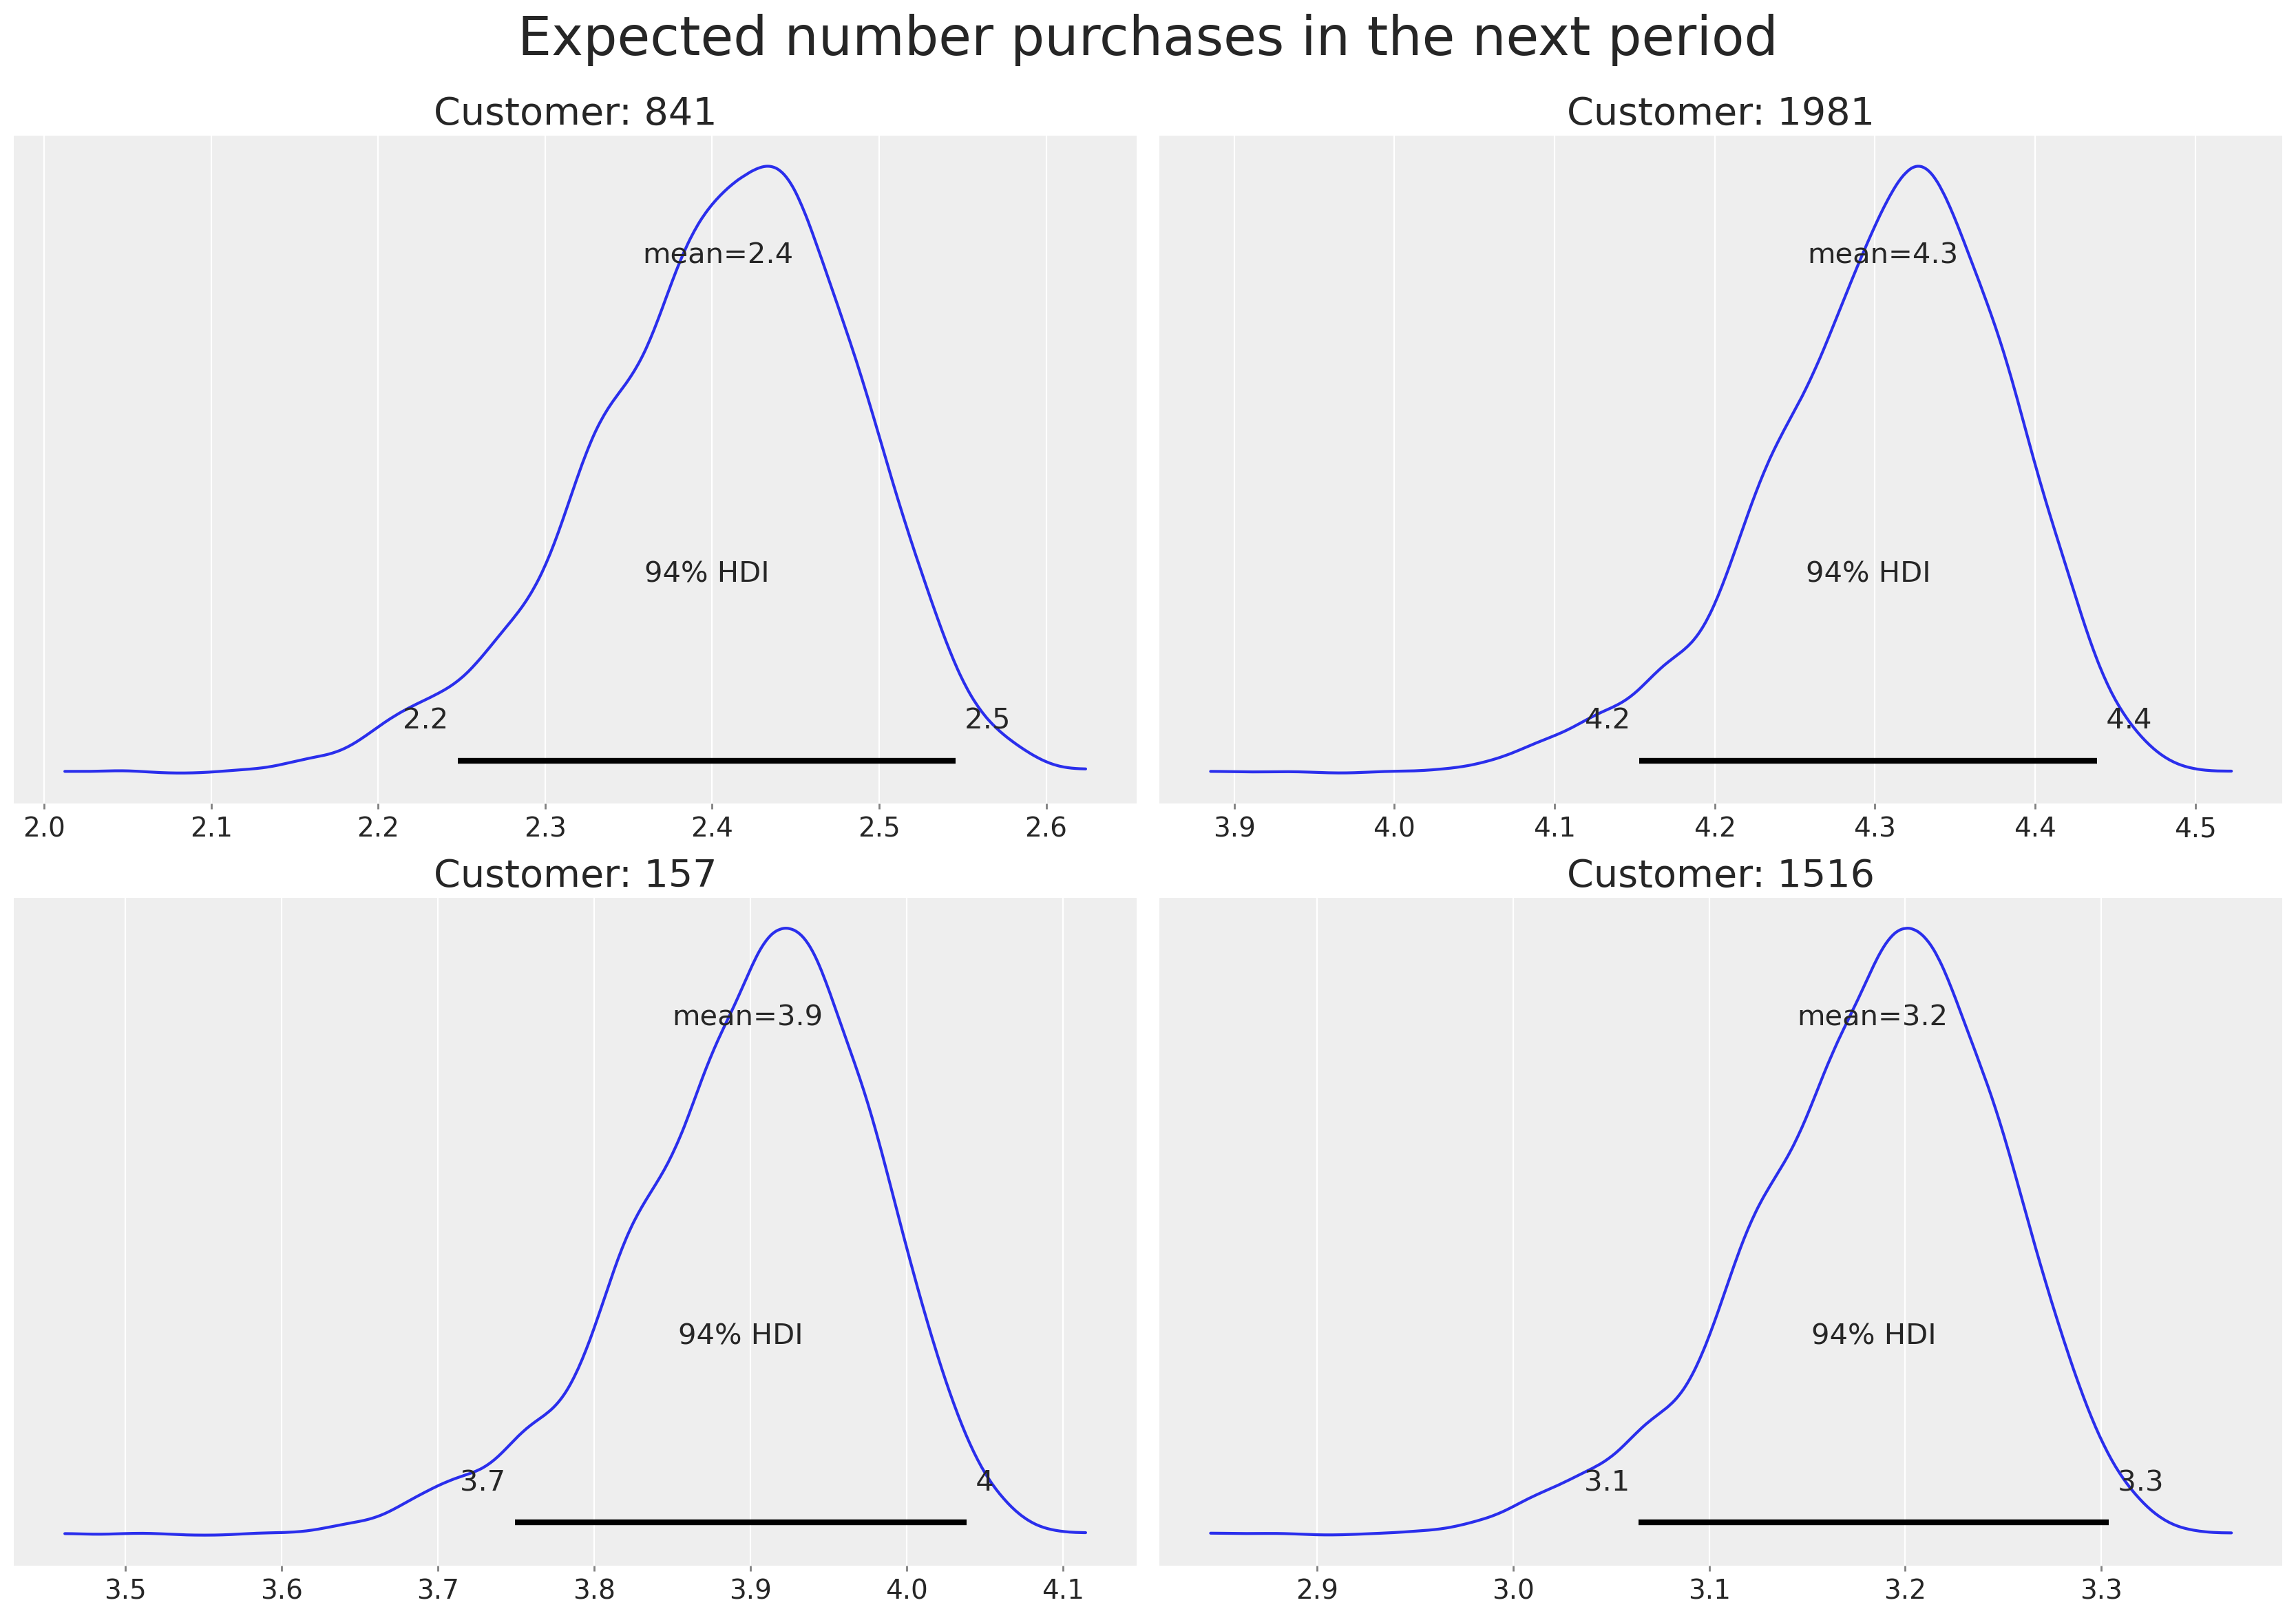

In [15]:
ids = [841, 1981, 157, 1516]
ax = az.plot_posterior(num_purchases.sel(customer_id=ids), grid=(2, 2))
for axi, id in zip(ax.ravel(), ids, strict=False):
    axi.set_title(f"Customer: {id}", size=20)
plt.suptitle("Expected number purchases in the next period", fontsize=28, y=1.05);

### Predicting purchase behavior of a new customer

We can use the fitted model to predict the number of purchases for a fresh new customer.

In [16]:
az.plot_posterior(
    bgm.expected_purchases_new_customer(t=10)
)
plt.title("Expected purchases of a new customer in the first 10 periods");

/Users/coltallen/miniconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/plots/plot_utils.py:272: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (2357) in plot_posterior, generating only 40 plots
  warnings.warn(


### Customer Probability Histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. 

Let look at active customer 1516 and assess the change in probability that the user will ever return if they do no other purchases in the next 9 time periods.

In [17]:
customer_1516 = rfm_data.loc[1515]
customer_1516

customer_id       1516.000000
frequency           27.000000
recency             67.000000
T                   70.000000
monetary_value      51.944074
Name: 1515, dtype: float64

In [20]:
customer_1516_history = pd.DataFrame(dict(
    customer_id=np.full(10, 1515, dtype="int"),
    frequency=np.full(10, customer_1516["frequency"], dtype="int"),
    recency=np.full(10, customer_1516["recency"]),
    T=(np.arange(0, 10) + customer_1516["recency"]).astype("int"),

))
customer_1516_history

,customer_id,frequency,recency,T
0,1515,27,67.0,67
1,1515,27,67.0,68
2,1515,27,67.0,69
3,1515,27,67.0,70
4,1515,27,67.0,71
5,1515,27,67.0,72
6,1515,27,67.0,73
7,1515,27,67.0,74
8,1515,27,67.0,75
9,1515,27,67.0,76


In [21]:
p_alive = bgm.expected_probability_alive(data=customer_1516_history)

ValueError: Column customer_id has duplicate entries

In [ ]:
az.plot_hdi(customer_1516_history["T"], p_alive, color="C0")
plt.plot(customer_1516_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_1516_history["recency"].iloc[0], c="black", ls="--", label="Purchase")

plt.title("Probability Customer 1516 will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

We can see that, if no purchases are being made in the next 9 weeks, the model has low confidence that the costumer will ever return. What if they had done one purchase in between?

In [ ]:
customer_1516_history.loc[7:,"frequency"] += 1
customer_1516_history.loc[7:,"recency"] = customer_1516_history.loc[7,"T"] - 0.5
customer_1516_history

In [ ]:
p_alive = bgm.expected_probability_alive(data=customer_1516_history["ID"])

In [ ]:
az.plot_hdi(customer_1516_history["T"], p_alive, color="C0")
plt.plot(customer_1516_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_1516_history["recency"].iloc[0], c="black", ls="--", label="Purchase")
plt.axvline(customer_1516_history["recency"].iloc[-1], c="black", ls="--")

plt.title("Probability Customer 1516 will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

From the plot above, say that customer 1516 makes a purchase at week 73.5, just over 6 weeks after they have made their last recorded purchase. We can see that the probability of the customer returning quickly goes back up!

## Estimating Customer Lifetime Value Using the Gamma-Gamma Model

Until now we’ve focused mainly on transaction frequencies and probabilities, but to estimate economic value we can use the Gamma-Gamma model.

The Gamma-Gamma model assumes at least 1 repeat transaction has been observed per customer. As such we filter out those with zero repeat purchases.

In [ ]:
nonzero_data = rfm_data.query("frequency>0")
nonzero_data

If computing the monetary value from your own data, note that it is the *mean* of a given customer’s value, *not* the sum. `monetary_value` can be used to represent profit, or revenue, or any value as long as it is consistently calculated for each customer.

The Gamma-Gamma model relies upon the important assumption there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation is less than 0.3:

In [ ]:
nonzero_data[['monetary_value', 'frequency']].corr()

Transaction frequencies and monetary values are uncorrelated; we can now fit our Gamma-Gamma model to predict average spend and expected lifetime values of our customers

The Gamma-Gamma model takes in a 'data' parameter, a pandas DataFrame with 3 columns representing Customer ID, average spend of repeat purchases, and number of repeat purchase for that customer. As with the BG/NBD model, these parameters are given HalfFlat priors which can be too diffuse for small datasets. For this example, we will use the default priors, but other priors can be specified just like with the BG/NBD example above.

In [ ]:
dataset = pd.DataFrame({
    'customer_id': nonzero_data.index,
    'mean_transaction_value': nonzero_data["monetary_value"],
    'frequency': nonzero_data["frequency"],
})

In [ ]:
gg = clv.GammaGammaModel(
    data = dataset
)
gg.build_model()
gg

By default, `fit` approximates full Bayesian posterior using [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) sampling provided by `pymc.sample`. If the full posterior is not needed or MCMC sampling is too slow, users can obtain the single [maximum a posteriori estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) via the `fit_method` kwarg.

In [ ]:
gg.fit(fit_method="map");

In [ ]:
gg.fit_summary()

In [ ]:
gg.fit();

In [ ]:
gg.fit_summary()

In [ ]:
az.plot_posterior(gg.fit_result);

### Predicting spend value of customers

Having fit our model, we can now use it to predict the conditional, expected average lifetime value of our customers, including those with zero repeat purchases.

In [ ]:
expected_spend = gg.expected_customer_spend(
    customer_id=rfm_data.index,
    mean_transaction_value=rfm_data["monetary_value"],
    frequency=rfm_data["frequency"],
)

In [ ]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

In [ ]:
labeller = MapLabeller(var_name_map={"x": "customer"})
az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True, labeller=labeller)
plt.xlabel("Expected mean spend");

We can also look at the average expected mean spend across all customers

In [ ]:
az.summary(expected_spend.mean("customer_id"), kind="stats")

In [ ]:
az.plot_posterior(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")
plt.title("Expected mean spend of all customers");

### Predicting spend value of a new customer

In [ ]:
az.plot_posterior(
    gg.expected_new_customer_spend()
)
plt.title("Expected mean spend of a new customer");

### Estimating CLV

Finally, we can combine the GG with the BG/NBD model to obtain an estimate of the customer lifetime value. This relies on the [Discounted cash flow](https://en.wikipedia.org/wiki/Discounted_cash_flow) model, adjusting for cost of capital:

In [ ]:
clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm,
    customer_id=rfm_data.index,
    mean_transaction_value=rfm_data["monetary_value"],
    frequency=rfm_data["frequency"],
    recency=rfm_data["recency"],
    T=rfm_data["T"],
    time=12, # months
    discount_rate=0.01, # monthly discount rate ~ 12.7% annually
    freq="W", # Our original data is in weeks
)

In [ ]:
az.summary(clv_estimate.isel(customer_id=range(10)), kind="stats")

In [ ]:
az.plot_forest(clv_estimate.isel(customer_id=range(10)), combined=True, labeller=labeller)
plt.xlabel("Expected CLV");

According to our models, customer[5] has a much higher expected CLV. There is also a large variability in this estimate that arises solely from uncertainty in the parameters of the BG/NBD and GG models. 

In general, these models tend to induce a strong correlation between expected CLV and uncertainty. This modelling of uncertainty can be very useful when making marketing decisions.